## Importing Libraries and Loading Dataset

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import os
import h5py
import matplotlib.image as mpimg
import IPython.display as ipd
import librosa

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

In [111]:
data = pd.read_csv("dataset.csv")
print(data.head())

                       IMAGE     mfcc_1     mfcc_2     mfcc_3     mfcc_4  \
0  images/forest/forest0.png  15.795384  -3.442518 -25.316836 -33.412104   
1  images/forest/forest1.png  15.883880  -3.494075 -21.189490 -18.077115   
2  images/forest/forest2.png  17.872629 -18.877467 -31.665319 -47.045579   
3  images/forest/forest3.png  16.843997  -3.527753 -21.282970 -24.248141   
4  images/forest/forest4.png  16.128583  -4.267328 -25.608325 -20.231084   

      mfcc_5     mfcc_6     mfcc_7     mfcc_8     mfcc_9  ...    mfcc_97  \
0   2.447290 -46.981182  12.889984 -23.588534 -22.625879  ... -43.876462   
1   4.284962 -27.014271   3.666955  -9.091312  -3.746509  ... -33.883092   
2   1.813430 -45.899877  14.975982 -24.462396  -1.812962  ... -34.456028   
3  27.201589 -18.787674  30.093938  -1.922008  10.156418  ... -36.410615   
4  15.922823 -35.703313  16.307644  -3.547505   4.804142  ... -41.548915   

     mfcc_98    mfcc_99   mfcc_100   mfcc_101   mfcc_102   mfcc_103  \
0  20.697491 -2

### Visualizing CLASS1 and CLASS2 Distribution with Pie Charts

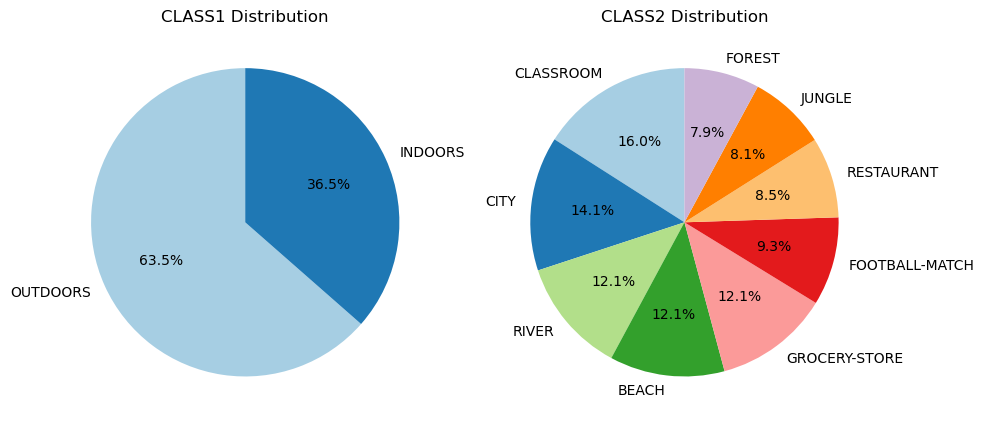

In [112]:
plt.figure(figsize=(10, 5))

# CLASS1 Distribution
plt.subplot(1, 2, 1)
class1_counts = data['CLASS1'].value_counts()
plt.pie(class1_counts, labels=class1_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('CLASS1 Distribution')

# CLASS2 Distribution
plt.subplot(1, 2, 2)
class2_counts = data['CLASS2'].value_counts()
plt.pie(class2_counts, labels=class2_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('CLASS2 Distribution')

plt.tight_layout()
plt.show()

CLASS1: Outdoors (63.5%) dominates over Indoors (36.5%), indicating a slight class imbalance.
CLASS2: Categories are more balanced, with Classroom (16%) as the largest and Forest (7.9%) as the smallest class.

### Preparing Data and Features for Audio and Images

In [113]:
data['CLASS1'] = data['CLASS1'].astype('category').cat.codes
data['CLASS2'] = data['CLASS2'].astype('category').cat.codes

In [114]:
mfcc_columns = [col for col in data.columns if 'mfcc' in col]
mfcc_values = data[mfcc_columns].iloc[0].values
audio_features = data[mfcc_columns].replace('[^.0-9-]', '', regex=True).astype(float).values
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [115]:
optimized_file = "image_features_optimized.h5"

print("Loading optimized features...")
with h5py.File(optimized_file, 'r') as hf:
    image_features_optimized = hf['features'][:]
print(f"Optimized features shape: {image_features_optimized.shape}")

scaler = StandardScaler()
image_features_scaled = scaler.fit_transform(image_features_optimized)
audio_features_scaled = scaler.fit_transform(audio_features)

Loading optimized features...
Optimized features shape: (17252, 512)


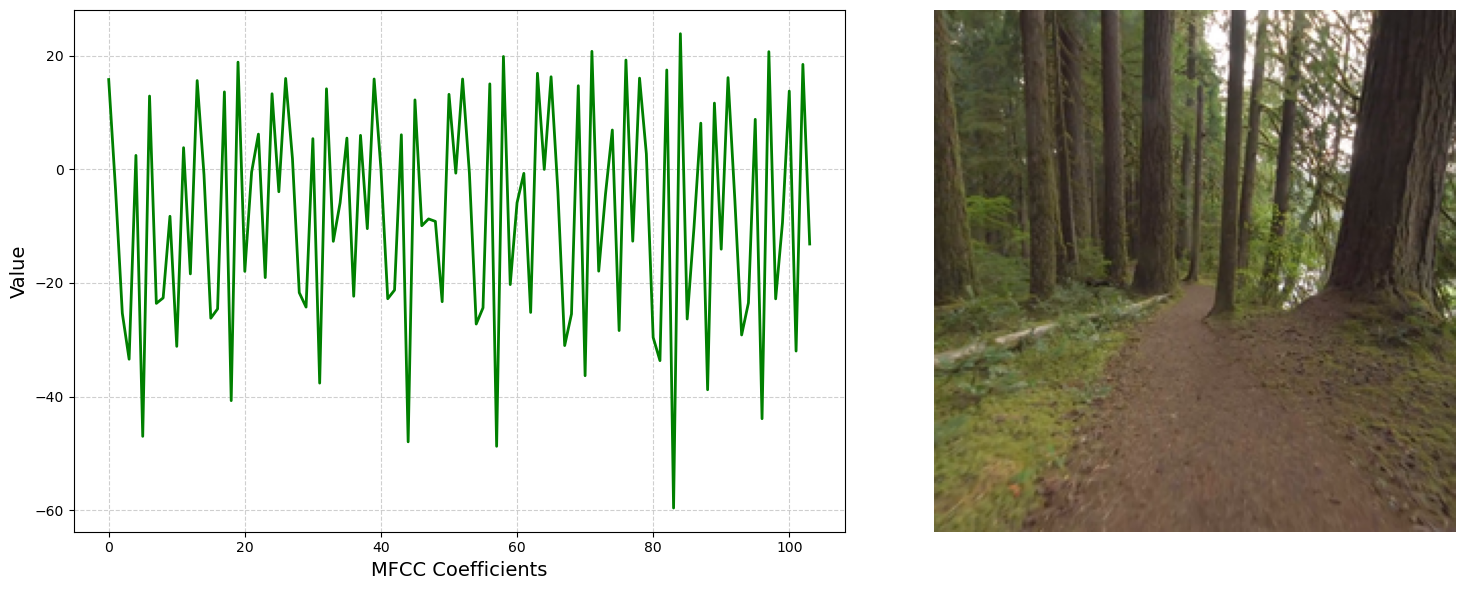

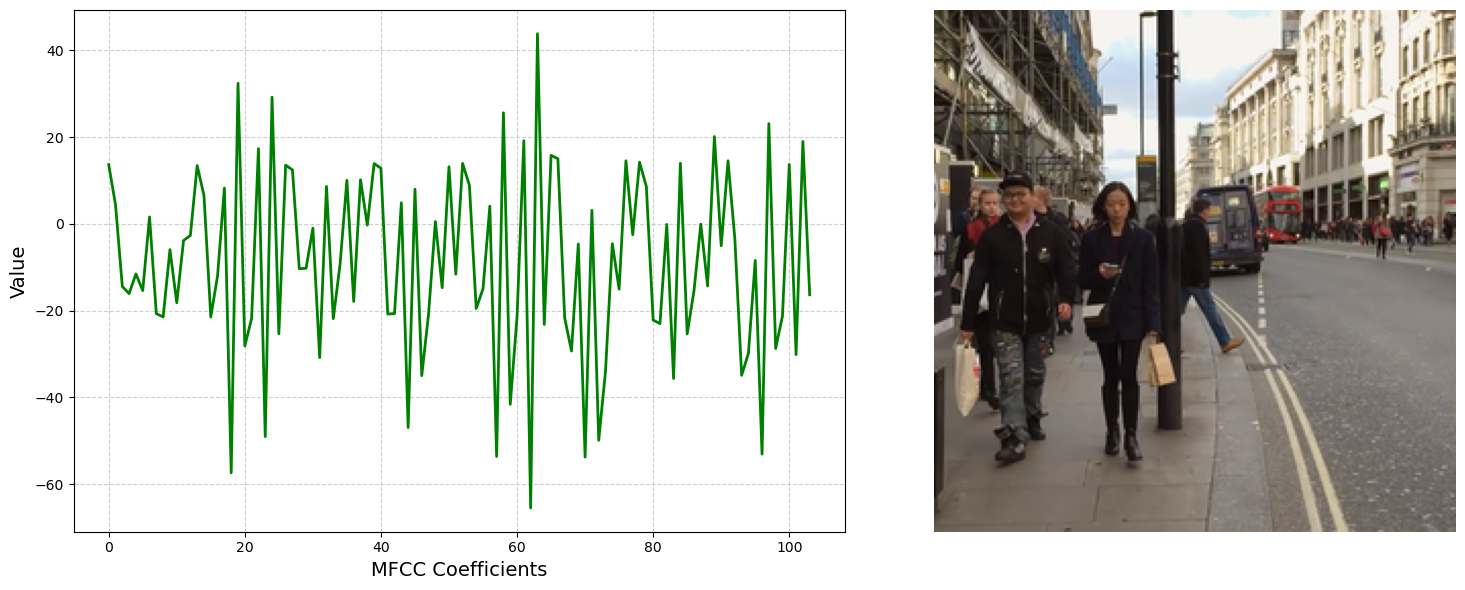

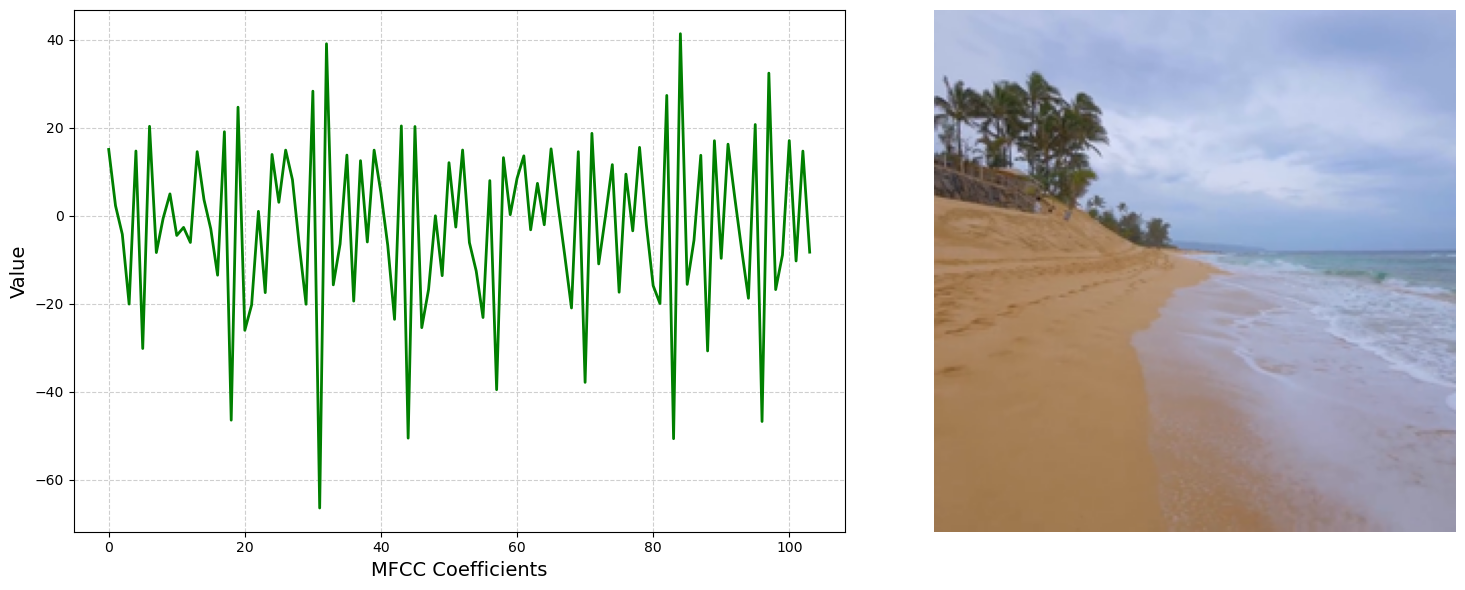

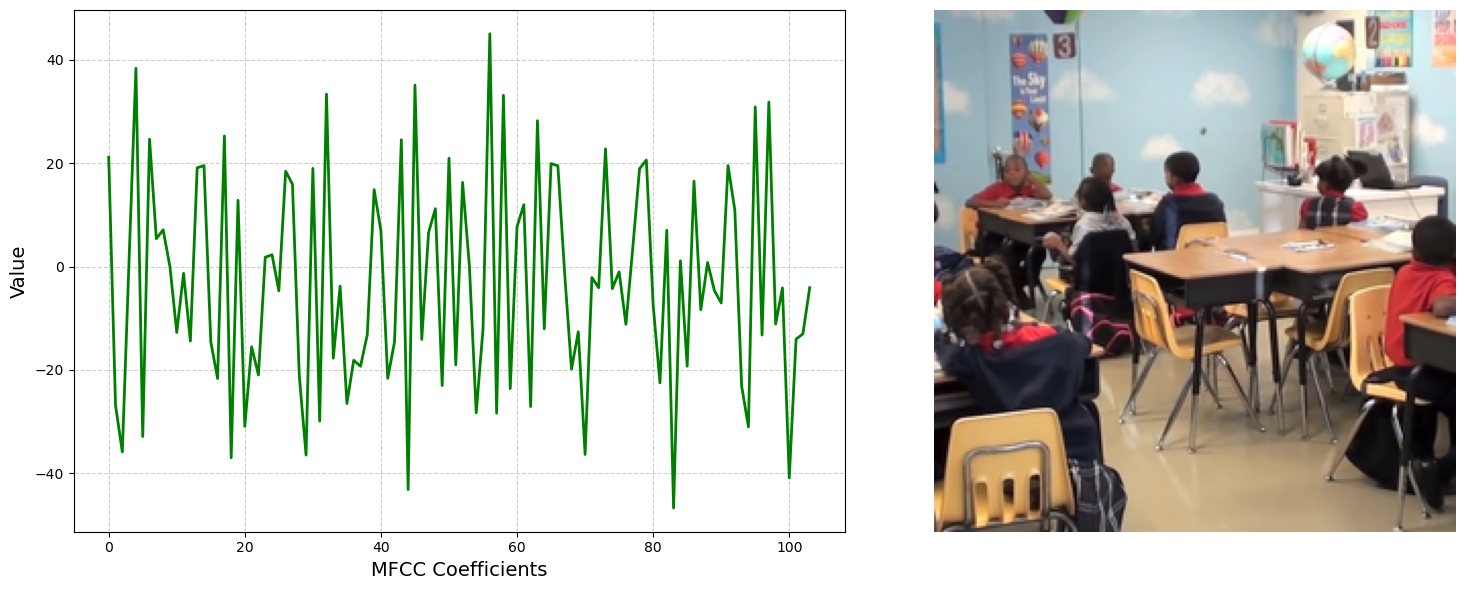

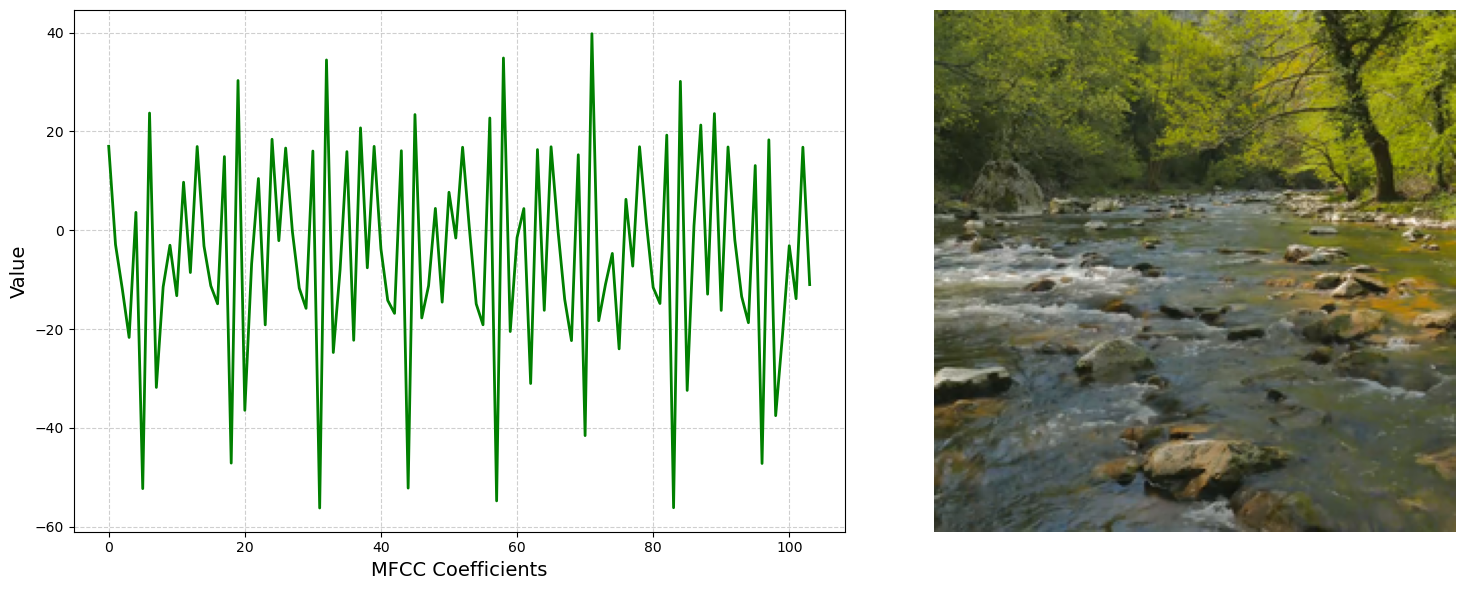

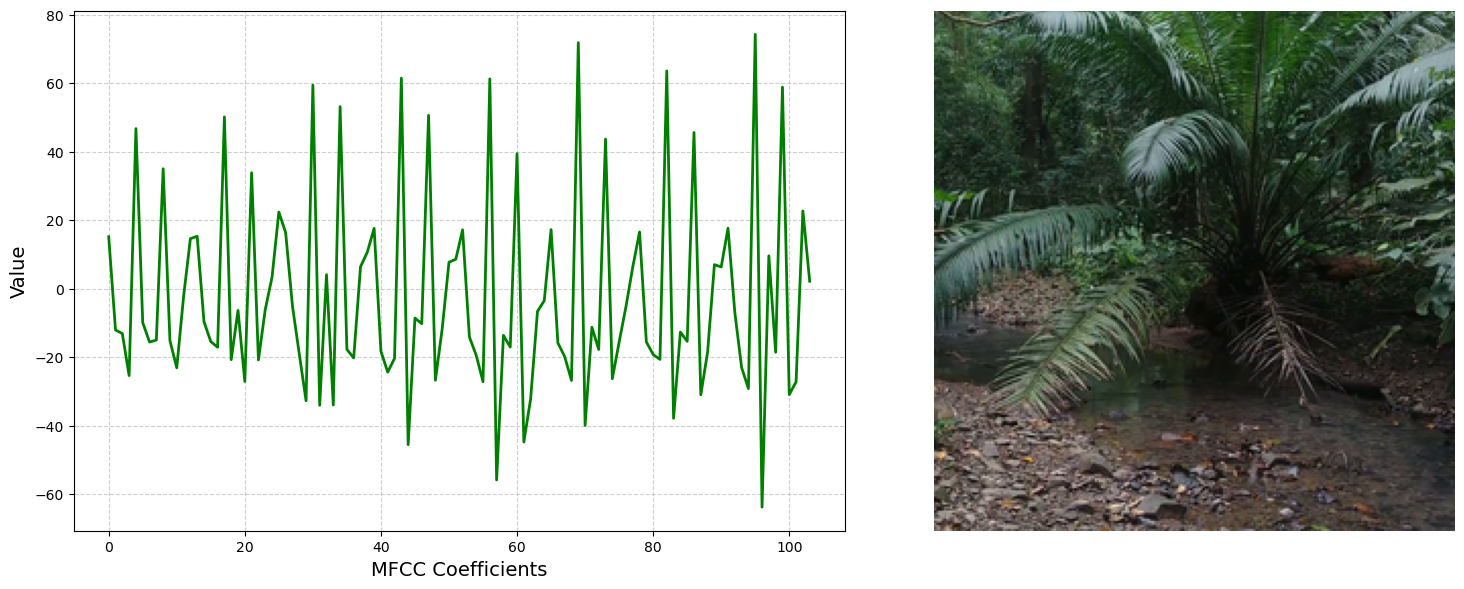

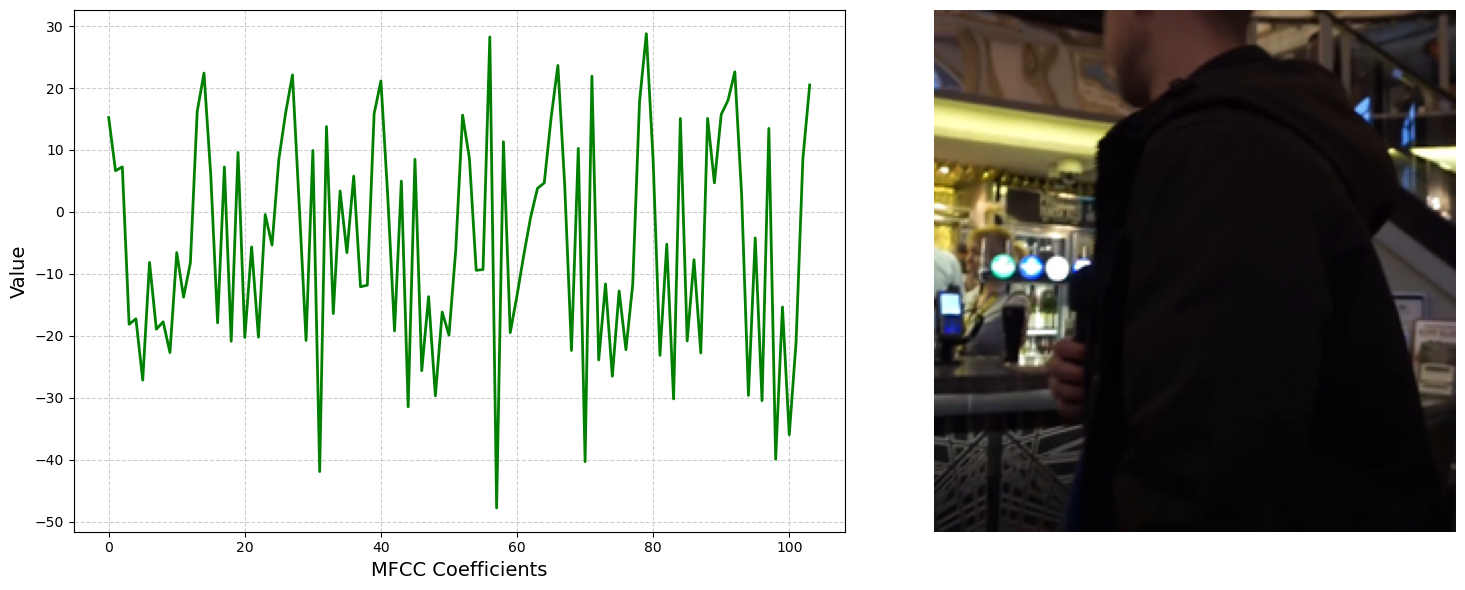

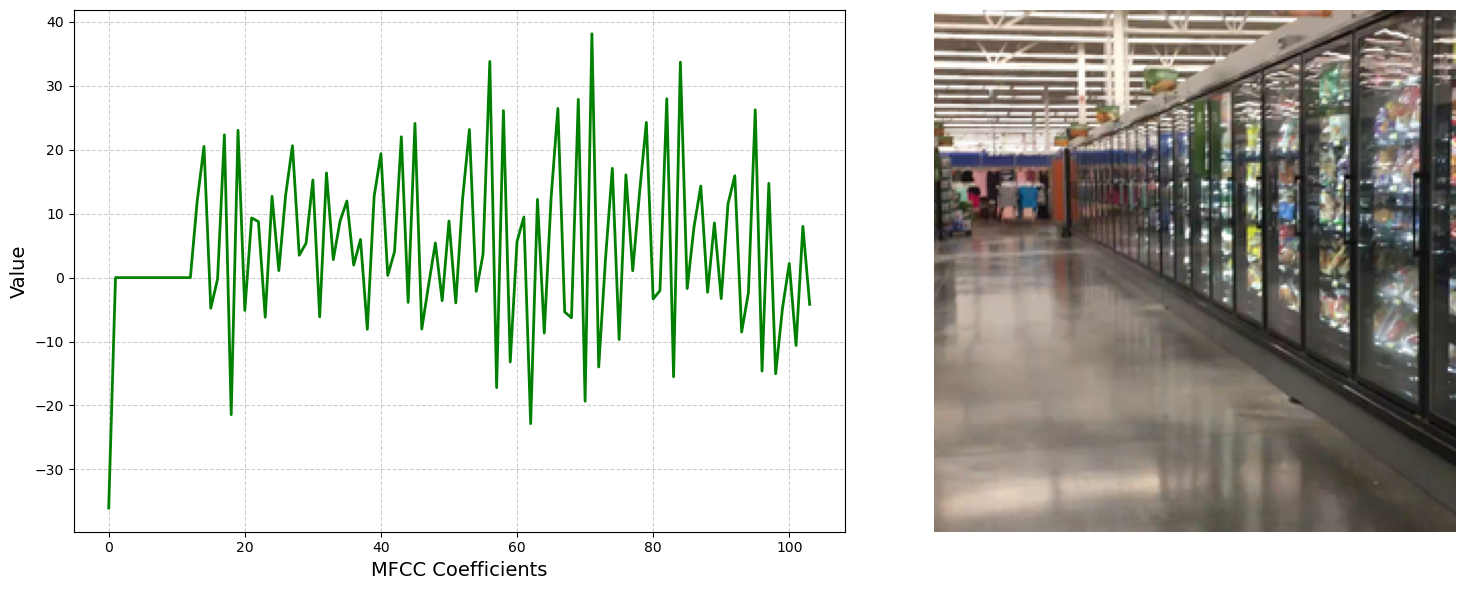

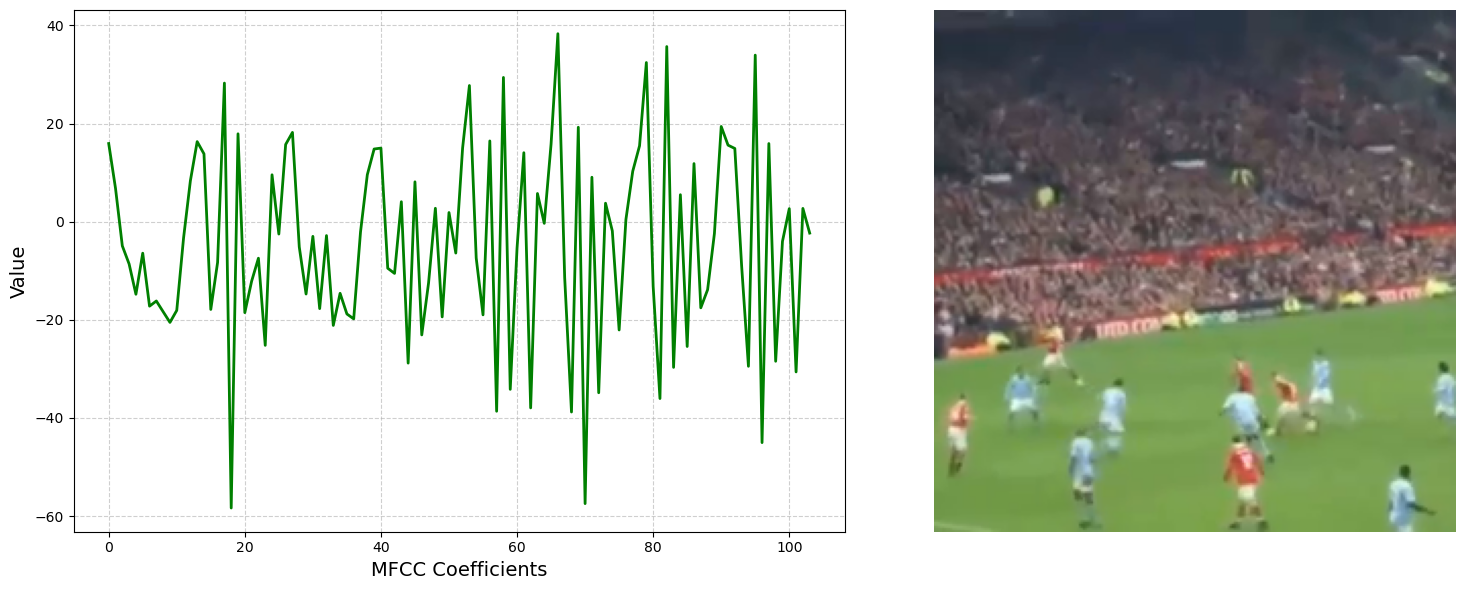

In [116]:
unique_classes = data['CLASS2'].unique()
class2_mapping = dict(enumerate(data['CLASS2'].astype('category').cat.categories))

for class_value in unique_classes:
    class_data = data[data['CLASS2'] == class_value]
    first_row = class_data.iloc[0]

    mfcc_values = first_row[mfcc_columns].values.astype(float)
    image_path = first_row['IMAGE']
    class_label = class2_mapping[class_value]

    if os.path.exists(image_path):
        img = mpimg.imread(image_path)

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        axes[0].plot(mfcc_values, color='green', linewidth=2)
        axes[0].set_xlabel("MFCC Coefficients", fontsize=14)
        axes[0].set_ylabel("Value", fontsize=14)
        axes[0].grid(True, linestyle='--', alpha=0.6)

        axes[1].imshow(img)
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

## Splitting Data

###  Saving and loading extracted image features using HDF5

In [117]:
X_train_audio, X_test_audio, y_train_audio_class1, y_test_audio_class1 = train_test_split(
    audio_features_scaled, data['CLASS1'], test_size=0.2, random_state=42
)

X_train_audio, X_test_audio, y_train_audio_class2, y_test_audio_class2 = train_test_split(
    audio_features_scaled, data['CLASS2'], test_size=0.2, random_state=42
)

X_train_image, X_test_image, y_train_image_class1, y_test_image_class1 = train_test_split(
    image_features_scaled, data['CLASS1'], test_size=0.2, random_state=42
)

X_train_image, X_test_image, y_train_image_class2, y_test_image_class2 = train_test_split(
    image_features_scaled, data['CLASS2'], test_size=0.2, random_state=42
)

X_train_combined, X_test_combined, y_train_combined_class1, y_test_combined_class1 = train_test_split(
    np.hstack([audio_features_scaled, image_features_scaled]), data['CLASS1'], test_size=0.2, random_state=42
)

X_train_combined, X_test_combined, y_train_combined_class2, y_test_combined_class2 = train_test_split(
    np.hstack([audio_features_scaled, image_features_scaled]), data['CLASS2'], test_size=0.2, random_state=42
)

### Training and Evaluating Model with ROC Curve Visualization

In [118]:
def train_and_evaluate_with_roc(X, y, label):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = DecisionTreeClassifier(max_depth = 12, random_state=42, class_weight='balanced')  
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(f"{label} Accuracy:", accuracy_score(y_test, y_pred))
    print(f"{label} Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    
    if hasattr(model, "predict_proba") and len(np.unique(y)) == 2: 
        y_score = model.predict_proba(X_test)[:, 1] 
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
        plt.plot(fpr, tpr, color="orange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
        plt.title(f'ROC Curve for {label}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print(f"Model {type(model).__name__} does not support probability prediction.")


### Visualizing Feature Clusters with t-SNE Plot

In [119]:
def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 6))
    for label in np.unique(labels):
        indices = np.where(labels == label)
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {label}', alpha=0.7)
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend()
    plt.show()

Due to the nature of this dataset, where machine learning is based on audio and image features transformed into numerical values, these features become hard for humans to interpret. Thus, for visualizing patterns and separations based on training categories, t-SNE is the most suitable method.

### Real T-SNE for audio

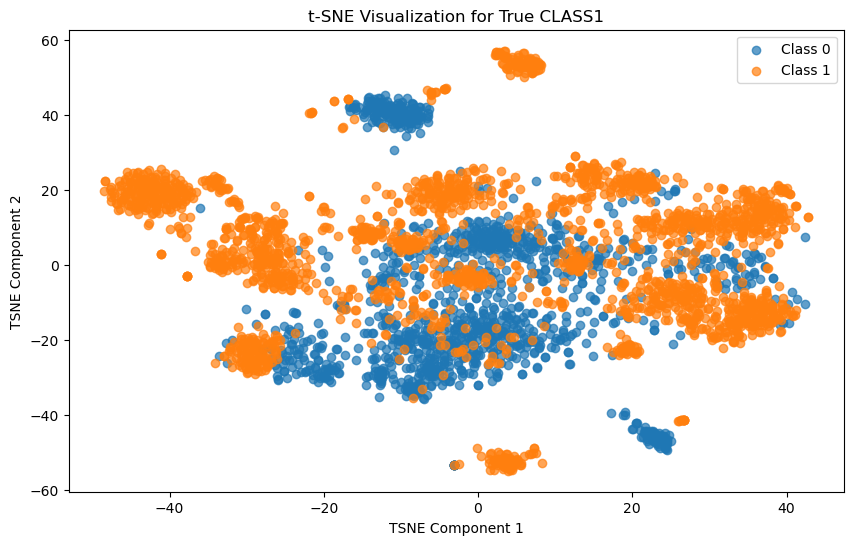

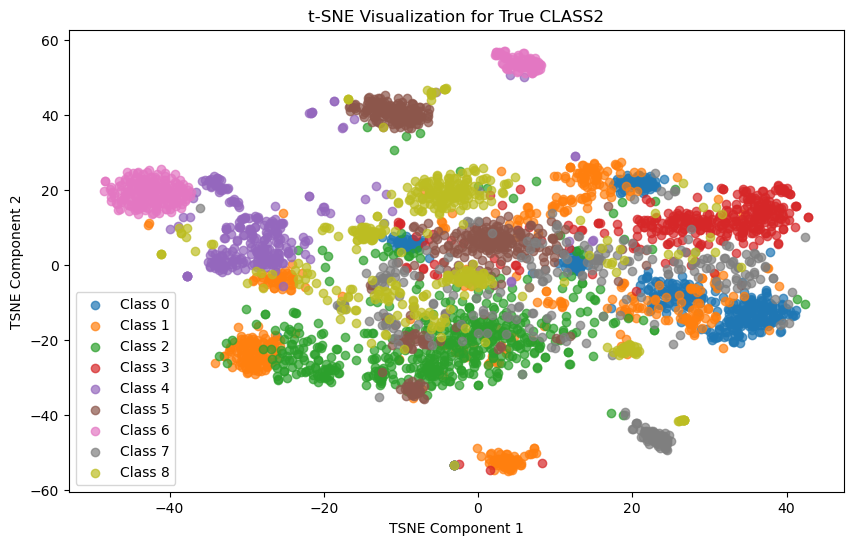

In [120]:
plot_tsne(X_test_audio, y_test_audio_class1, 't-SNE Visualization for True CLASS1')
plot_tsne(X_test_audio, y_test_audio_class2, 't-SNE Visualization for True CLASS2')

### Real T-SNE for photos

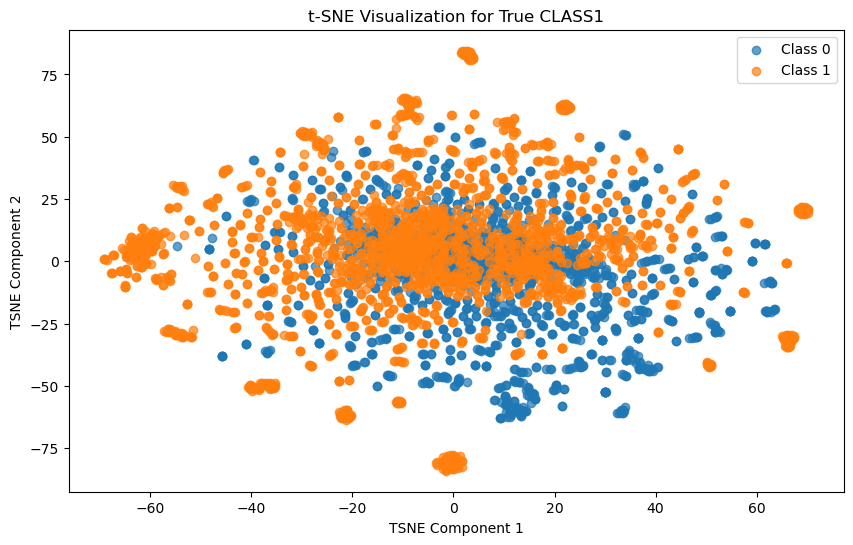

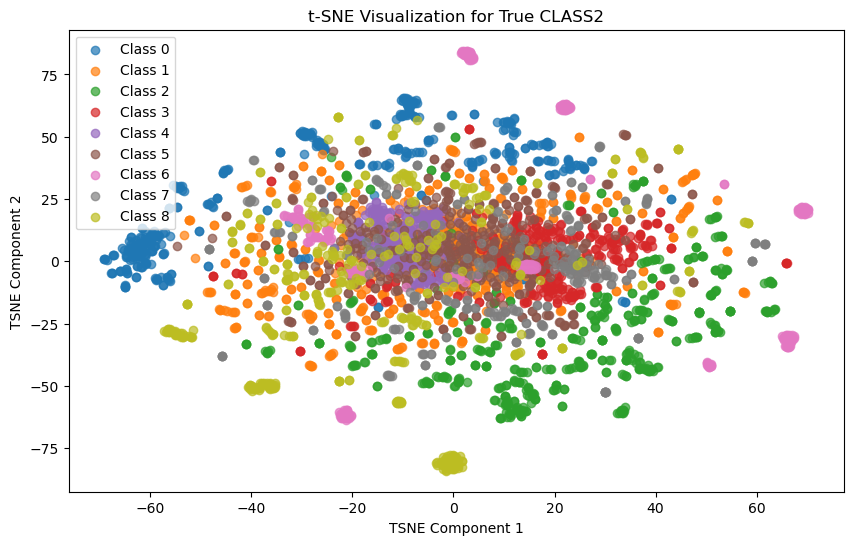

In [122]:
plot_tsne(X_test_image, y_test_image_class1, 't-SNE Visualization for True CLASS1')
plot_tsne(X_test_image, y_test_image_class2, 't-SNE Visualization for True CLASS2')

# Decision tree

# Sound

Audio CLASS1 Accuracy: 0.8033321260412893
Audio CLASS1 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74      1053
           1       0.84      0.85      0.84      1708

    accuracy                           0.80      2761
   macro avg       0.79      0.79      0.79      2761
weighted avg       0.80      0.80      0.80      2761



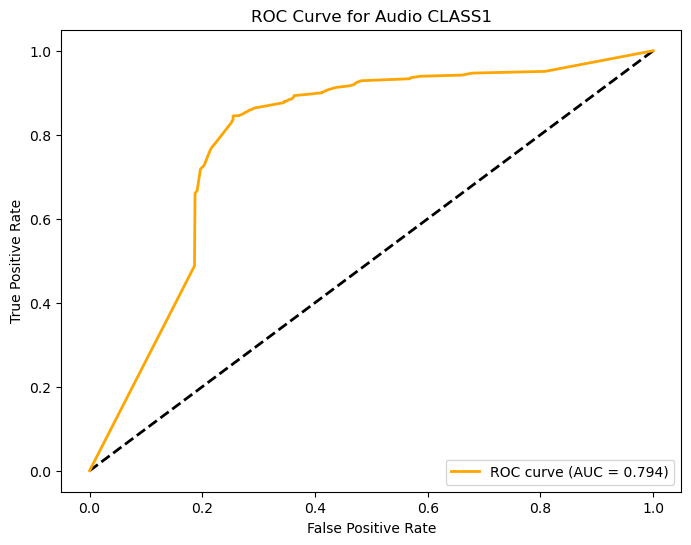

Audio CLASS2 Accuracy: 0.6432452010141253
Audio CLASS2 Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.69      0.64       324
           1       0.56      0.46      0.51       390
           2       0.77      0.67      0.72       454
           3       0.69      0.71      0.70       240
           4       0.77      0.81      0.79       214
           5       0.59      0.69      0.64       339
           6       0.94      0.88      0.91       230
           7       0.44      0.45      0.44       260
           8       0.54      0.55      0.54       310

    accuracy                           0.64      2761
   macro avg       0.65      0.66      0.65      2761
weighted avg       0.65      0.64      0.64      2761

Model DecisionTreeClassifier does not support probability prediction.


In [123]:
train_and_evaluate_with_roc(X_train_audio, y_train_audio_class1, "Audio CLASS1")
train_and_evaluate_with_roc(X_train_audio, y_train_audio_class2, "Audio CLASS2")

### t-SNE Visualization for Audio Features

In [ ]:
predicted_labels_class1 = np.argmax(audio_nn_class1.predict(X_test_image), axis=1)
predicted_labels_class2 = np.argmax(audio_nn_class2.predict(X_test_image), axis=1)

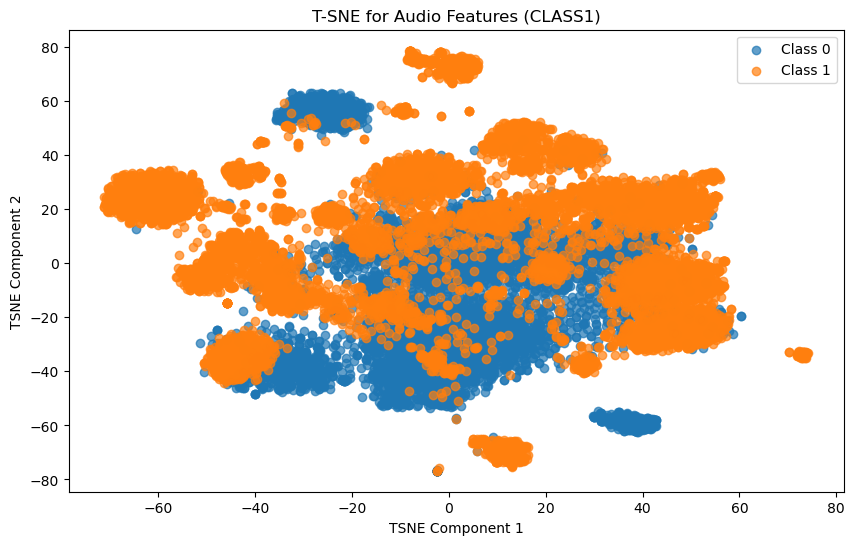

In [124]:
plot_tsne(X_test_audio, predicted_labels_class1, "T-SNE for Audio Features (CLASS1)")

The t-SNE visualization shows clusters for Outdoors and Indoors classes with some overlap. The pink and yellow clusters indicate areas where audio features (e.g., MFCC) provide separability.

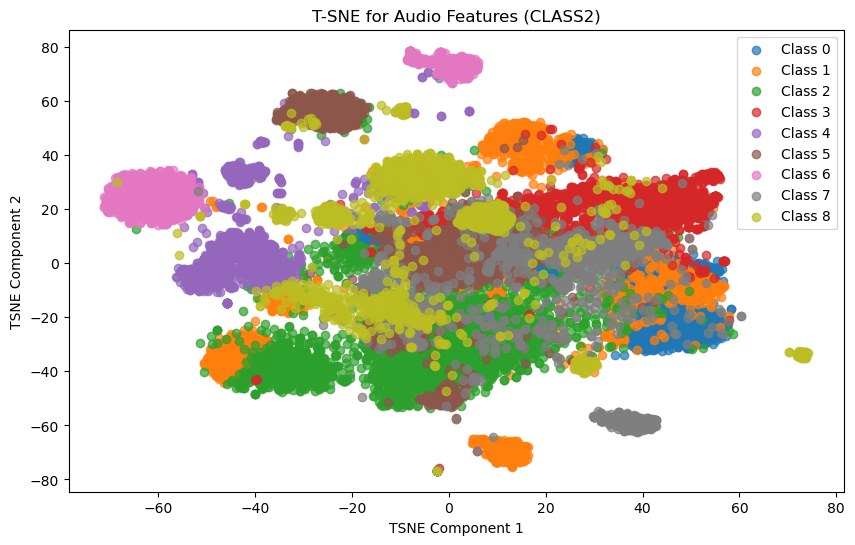

In [125]:
plot_tsne(audio_features_scaled, data['CLASS2'], "T-SNE for Audio Features (CLASS2)")

The t-SNE visualization for CLASS2 shows multiple clusters corresponding to different categories (e.g., Forest, City). While some clusters are distinct, others overlap, indicating shared audio features between certain environments.

# Images

Image CLASS1 Accuracy: 0.9692140528793916
Image CLASS1 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1053
           1       0.98      0.97      0.98      1708

    accuracy                           0.97      2761
   macro avg       0.97      0.97      0.97      2761
weighted avg       0.97      0.97      0.97      2761



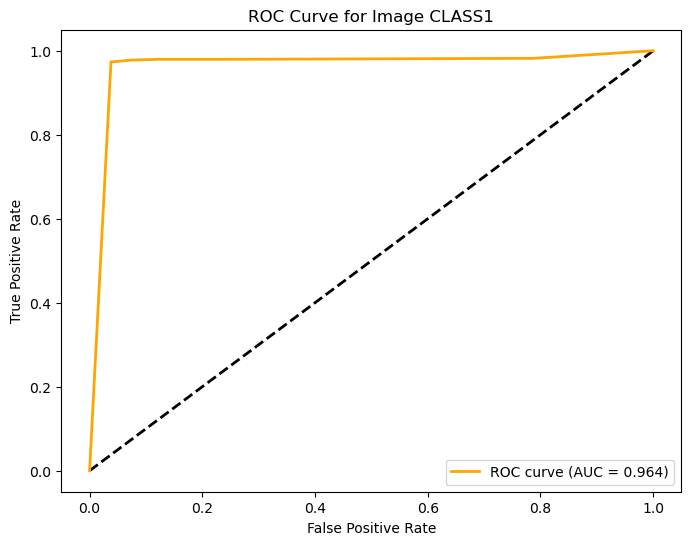

Image CLASS2 Accuracy: 0.9224918507787033
Image CLASS2 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       324
           1       0.93      0.89      0.91       390
           2       0.97      0.93      0.95       454
           3       0.97      0.93      0.95       240
           4       0.98      0.95      0.97       214
           5       0.88      0.89      0.89       339
           6       0.95      0.96      0.95       230
           7       0.77      0.89      0.82       260
           8       0.90      0.92      0.91       310

    accuracy                           0.92      2761
   macro avg       0.92      0.92      0.92      2761
weighted avg       0.93      0.92      0.92      2761

Model DecisionTreeClassifier does not support probability prediction.


In [126]:
train_and_evaluate_with_roc(X_train_image, y_train_image_class1, "Image CLASS1")
train_and_evaluate_with_roc(X_train_image, y_train_image_class2, "Image CLASS2")

### t-SNE Visualization for Image Features

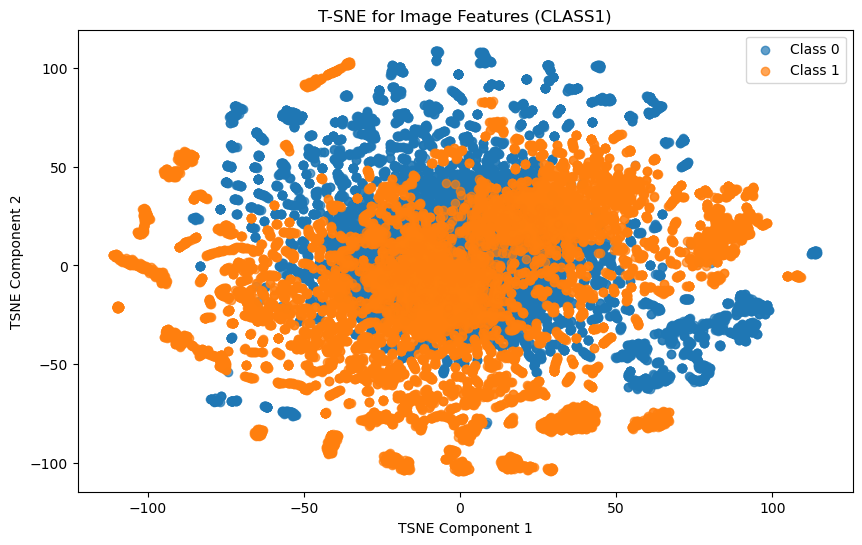

In [127]:
plot_tsne(image_features_scaled, data['CLASS1'], "T-SNE for Image Features (CLASS1)")

The t-SNE visualization for CLASS1 (Image Features) shows two main clusters representing Outdoors and Indoors classes. There is notable overlap between the clusters, indicating some shared visual features between the two environments.

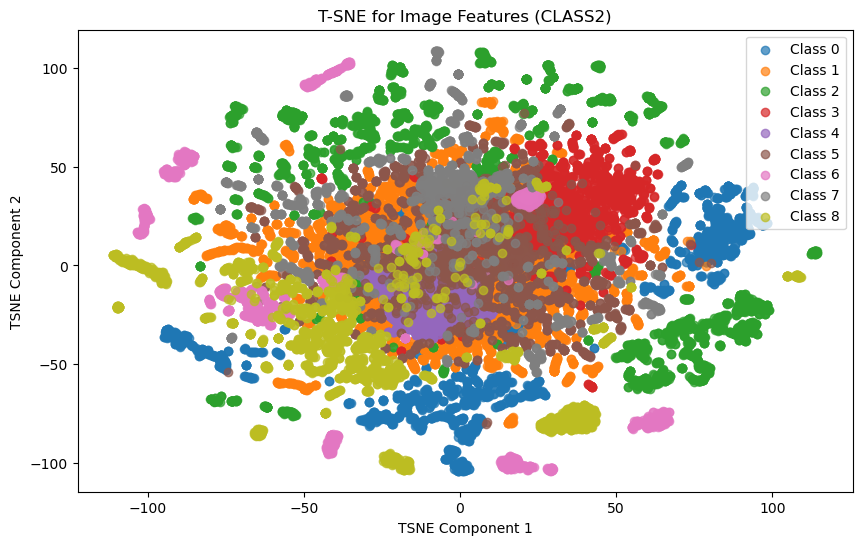

In [128]:
plot_tsne(image_features_scaled, data['CLASS2'], "T-SNE for Image Features (CLASS2)")

The t-SNE visualization for CLASS2 (Image Features) shows overlapping clusters for several categories, reflecting shared visual patterns. While some distinct clusters are visible (e.g., certain environments like "Beach" or "City"), the majority of classes exhibit significant overlap, suggesting that image features alone may not be sufficient to fully differentiate all categories.

# Multimodal ML with Audio and Images Combined

In [129]:
combined_features = np.hstack([image_features_optimized, audio_features])
combined_features_scaled = np.hstack([image_features_scaled, audio_features_scaled])

Combined CLASS1 Accuracy: 0.971749366171677
Combined CLASS1 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1053
           1       0.98      0.97      0.98      1708

    accuracy                           0.97      2761
   macro avg       0.97      0.97      0.97      2761
weighted avg       0.97      0.97      0.97      2761



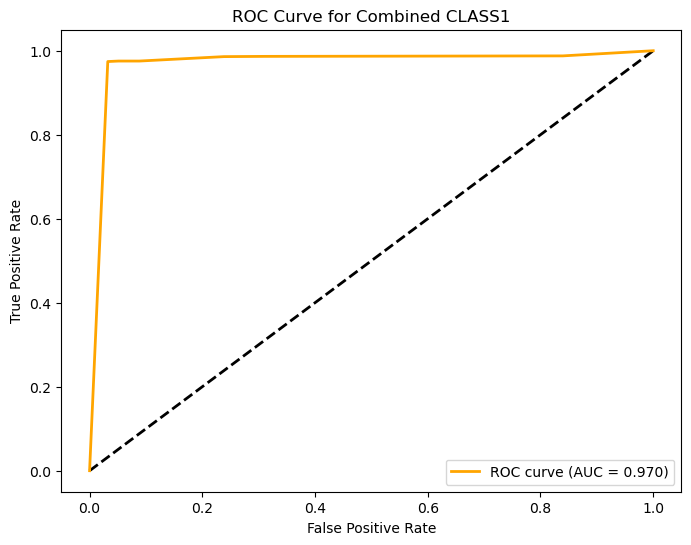

Combined CLASS2 Accuracy: 0.9206809127127852
Combined CLASS2 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97       324
           1       0.93      0.89      0.91       390
           2       0.98      0.94      0.96       454
           3       0.90      0.93      0.92       240
           4       0.96      0.93      0.94       214
           5       0.92      0.92      0.92       339
           6       0.94      0.93      0.94       230
           7       0.76      0.88      0.82       260
           8       0.88      0.93      0.90       310

    accuracy                           0.92      2761
   macro avg       0.92      0.92      0.92      2761
weighted avg       0.92      0.92      0.92      2761

Model DecisionTreeClassifier does not support probability prediction.


In [130]:
train_and_evaluate_with_roc(X_train_combined, y_train_combined_class1, "Combined CLASS1")
train_and_evaluate_with_roc(X_train_combined, y_train_combined_class2, "Combined CLASS2")

Сonfusion Matrix for Combined CLASS1 (Outdoors/Indoors) shows strong overall accuracy with minimal confusion.

Confusion Matrix for Combined CLASS2 (FOREST, CITY, etc.):
Some smaller classes, like Jungle, are more prone to confusion due to limited separability in features.

### t-SNE Visualization for Combined Features

In [131]:
combined_features_scaled = np.hstack([image_features_scaled, audio_features_scaled])

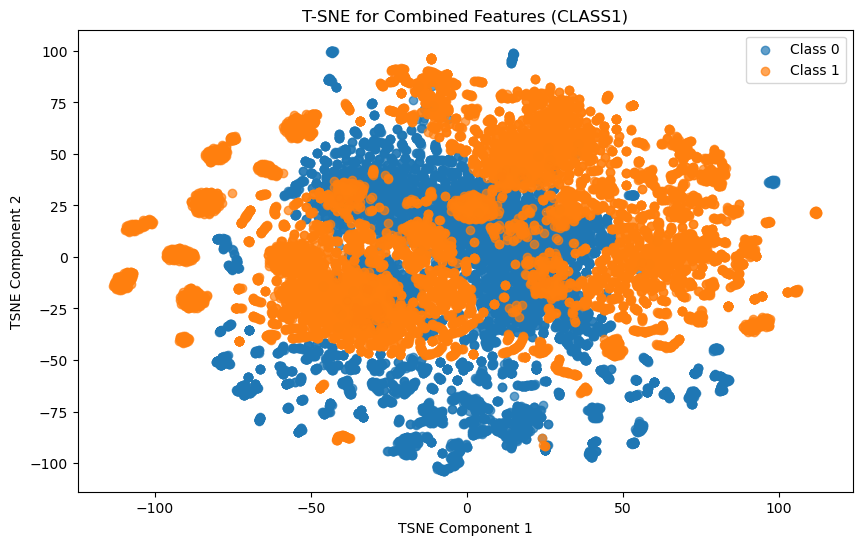

In [132]:
plot_tsne(combined_features_scaled, data['CLASS1'], "T-SNE for Combined Features (CLASS1)")

The t-SNE visualization for CLASS1 (Combined Features) shows improved clustering compared to individual audio or image features. The combination of features leads to clearer separability of the Outdoors and Indoors classes, although some overlap remains, indicating shared characteristics between these categories.

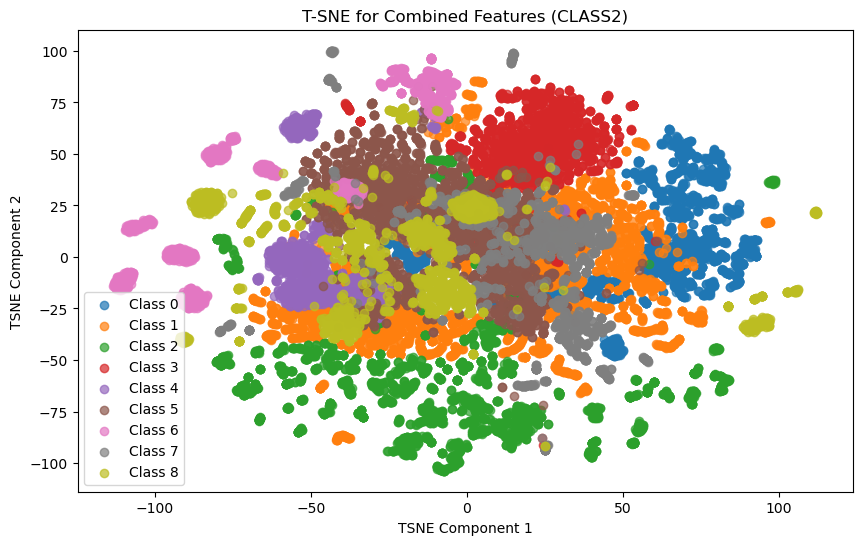

In [133]:
plot_tsne(combined_features_scaled, data['CLASS2'], "T-SNE for Combined Features (CLASS2)")

The t-SNE visualization for CLASS2 (Combined Features) shows improved cluster separability compared to individual features. While overlap still exists among some categories (e.g., Jungle and Forest), the combination of audio and image features provides better differentiation between classes such as City and Classroom, highlighting the benefit of multimodal data.

# Neural Network

## Audio

### Preparing Data

In [134]:
y_audio_class1_nn = to_categorical(y_train_audio_class1)
y_audio_class2_nn = to_categorical(y_train_audio_class2)

### Building Neural Network

In [135]:
audio_nn_class1 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_audio.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_audio_class1_nn.shape[1], activation='softmax')
])

audio_nn_class2 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_audio.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_audio_class2_nn.shape[1], activation='softmax')
])

C:\Users\pharp\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the Model

In [136]:
audio_nn_class1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
audio_nn_class2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### Training the Model

In [137]:
audio_history_class1 = audio_nn_class1.fit(
    X_train_audio, y_audio_class1_nn,
    validation_split=0.2,
    epochs=30, batch_size=32, verbose=1
)

audio_history_class2 = audio_nn_class2.fit(
    X_train_audio, y_audio_class2_nn,
    validation_split=0.2,
    epochs=30, batch_size=32, verbose=1
)

Epoch 1/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7923 - loss: 0.4436 - val_accuracy: 0.9080 - val_loss: 0.2414
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8934 - loss: 0.2710 - val_accuracy: 0.9214 - val_loss: 0.1997
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9201 - loss: 0.1963 - val_accuracy: 0.9315 - val_loss: 0.1676
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9308 - loss: 0.1785 - val_accuracy: 0.9294 - val_loss: 0.1653
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9402 - loss: 0.1540 - val_accuracy: 0.9413 - val_loss: 0.1424
Epoch 6/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9501 - loss: 0.1276 - val_accuracy: 0.9468 - val_loss: 0.1342
Epoch 7/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9517 - loss: 0.1195 - val_accuracy: 0.9453 - val_loss: 0.1427
Epoch 8/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9518 - loss: 0.1230 - val_accuracy: 0.

### Evaluating the Model

In [138]:
audio_test_class1 = audio_nn_class1.evaluate(X_test_audio, to_categorical(y_test_audio_class1), verbose=0)
print(f"Audio CLASS1 Test Accuracy: {audio_test_class1[1]:.2f}")

audio_test_class2 = audio_nn_class2.evaluate(X_test_audio, to_categorical(y_test_audio_class2), verbose=0)
print(f"Audio CLASS2 Test Accuracy: {audio_test_class2[1]:.2f}")

Audio CLASS1 Test Accuracy: 0.97
Audio CLASS2 Test Accuracy: 0.94


### Visualizing Training and Validation Accuracy

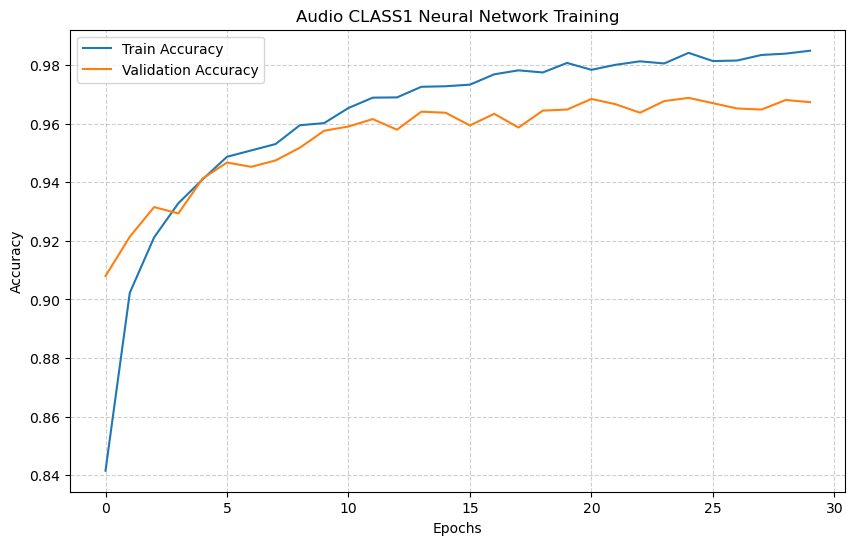

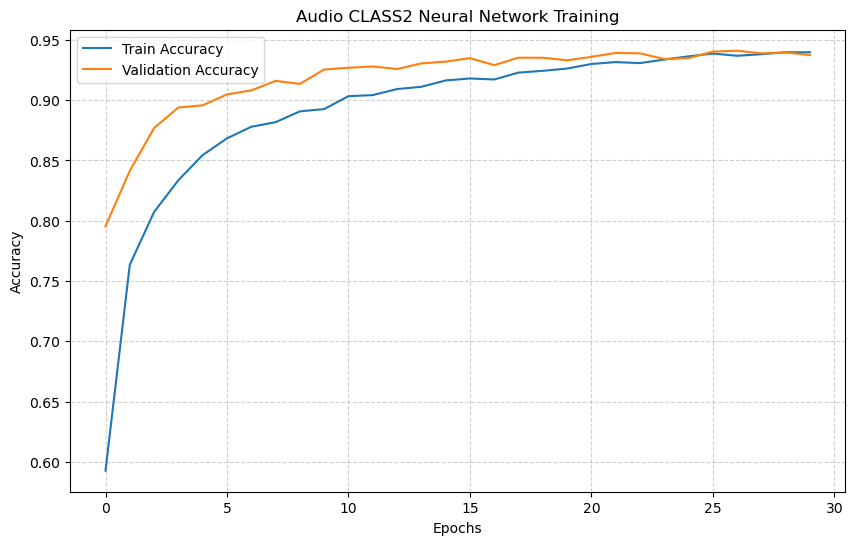

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(audio_history_class1.history['accuracy'], label='Train Accuracy')
plt.plot(audio_history_class1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Audio CLASS1 Neural Network Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(audio_history_class2.history['accuracy'], label='Train Accuracy')
plt.plot(audio_history_class2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Audio CLASS2 Neural Network Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### T-SNE

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


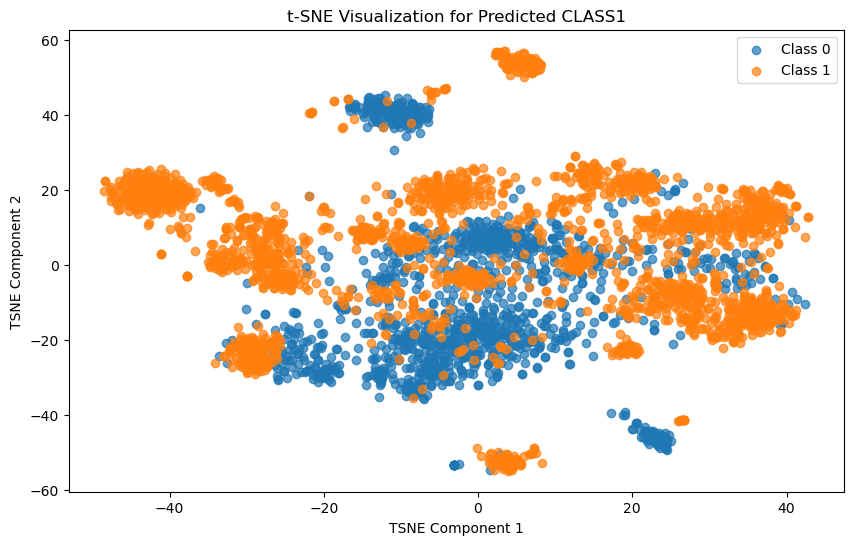

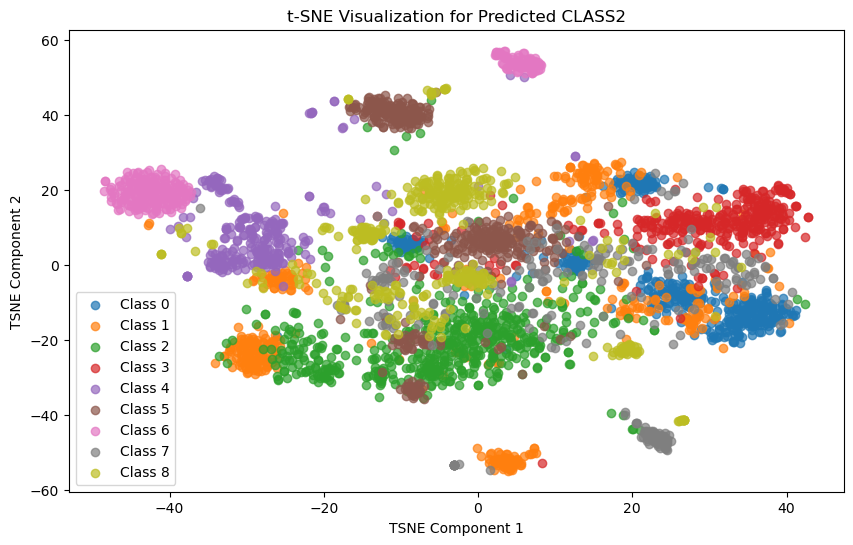

In [140]:
predicted_labels_class1 = np.argmax(audio_nn_class1.predict(X_test_audio), axis=1)
predicted_labels_class2 = np.argmax(audio_nn_class2.predict(X_test_audio), axis=1)

plot_tsne(X_test_audio, predicted_labels_class1, 't-SNE Visualization for Predicted CLASS1')
plot_tsne(X_test_audio, predicted_labels_class2, 't-SNE Visualization for Predicted CLASS2')

## Image

### Preparing Data

In [141]:
y_image_class1_nn = to_categorical(y_train_image_class1)
y_image_class2_nn = to_categorical(y_train_image_class2)

### Building Neural Network

In [142]:
image_nn_class1 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_image.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_image_class1_nn.shape[1], activation='softmax')
])

image_nn_class2 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_image.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_image_class2_nn.shape[1], activation='softmax')
])

C:\Users\pharp\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the Model

In [143]:
image_nn_class1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
image_nn_class2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### Training the Model

In [144]:
image_history_class1 = image_nn_class1.fit(
    X_train_image, y_image_class1_nn,
    validation_split=0.2,
    epochs=30, batch_size=32, verbose=1
)

image_history_class2 = image_nn_class2.fit(
    X_train_image, y_image_class2_nn,
    validation_split=0.2,
    epochs=30, batch_size=32, verbose=1
)

Epoch 1/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7516 - loss: 0.5412 - val_accuracy: 0.9859 - val_loss: 0.0392
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9836 - loss: 0.0557 - val_accuracy: 0.9895 - val_loss: 0.0301
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9911 - loss: 0.0238 - val_accuracy: 0.9902 - val_loss: 0.0312
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9941 - loss: 0.0175 - val_accuracy: 0.9895 - val_loss: 0.0289
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9976 - loss: 0.0073 - val_accuracy: 0.9935 - val_loss: 0.0250
Epoch 6/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9973 - loss: 0.0082 - val_accuracy: 0.9902 - val_loss: 0.0321
Epoch 7/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9917 - val_loss: 0.0276
Epoch 8/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9970 - loss: 0.0091 - val_accuracy: 0.

### Evaluating the Model

In [145]:
image_test_class1 = image_nn_class1.evaluate(X_test_image, to_categorical(y_test_image_class1), verbose=0)
print(f"Image CLASS1 Test Accuracy: {image_test_class1[1]:.2f}")

image_test_class2 = image_nn_class2.evaluate(X_test_image, to_categorical(y_test_image_class2), verbose=0)
print(f"Image CLASS2 Test Accuracy: {image_test_class2[1]:.2f}")

Image CLASS1 Test Accuracy: 0.99
Image CLASS2 Test Accuracy: 0.99


### Visualizing Training and Validation Accuracy

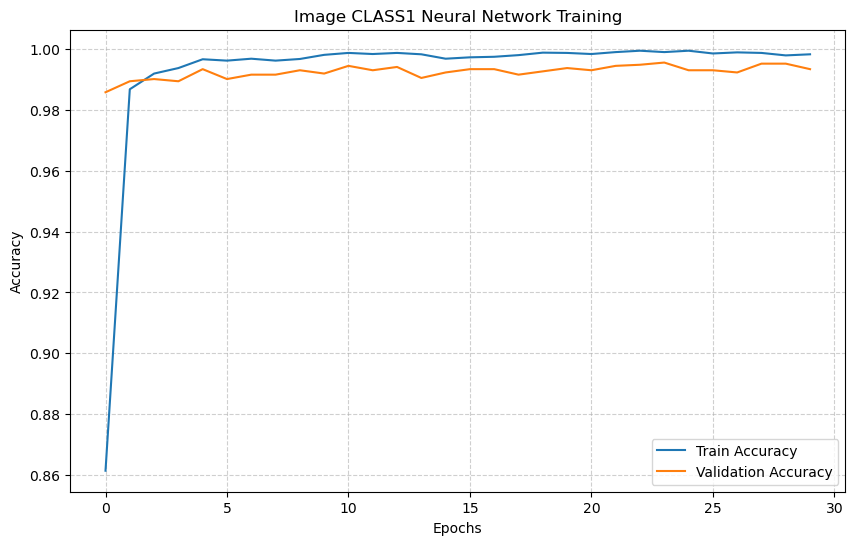

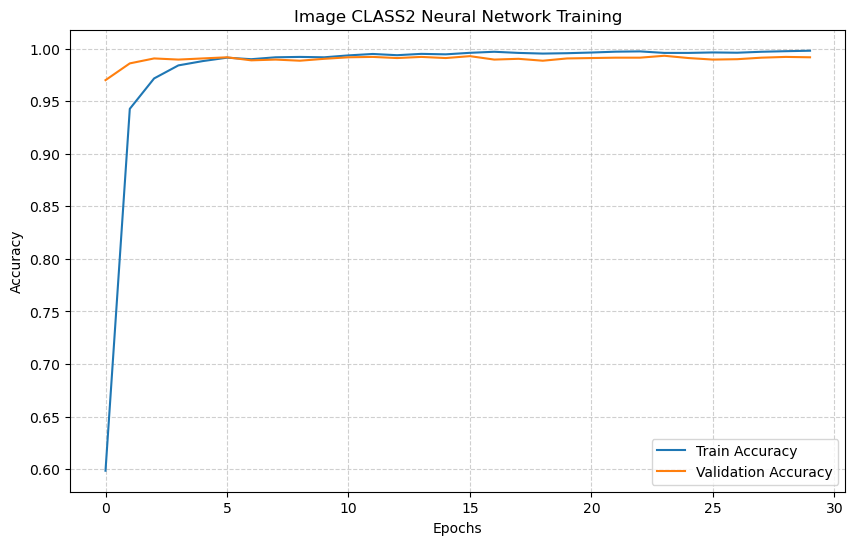

In [146]:
plt.figure(figsize=(10, 6))
plt.plot(image_history_class1.history['accuracy'], label='Train Accuracy')
plt.plot(image_history_class1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Image CLASS1 Neural Network Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(image_history_class2.history['accuracy'], label='Train Accuracy')
plt.plot(image_history_class2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Image CLASS2 Neural Network Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### T-SNE

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


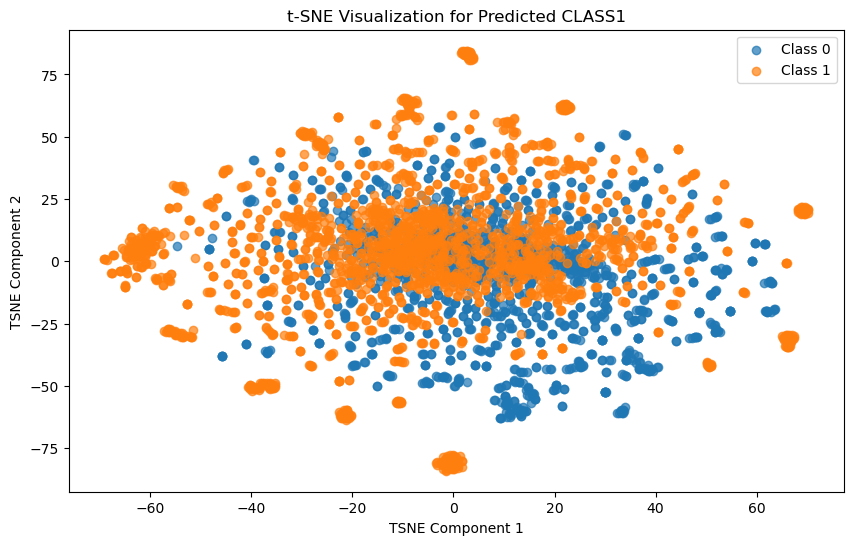

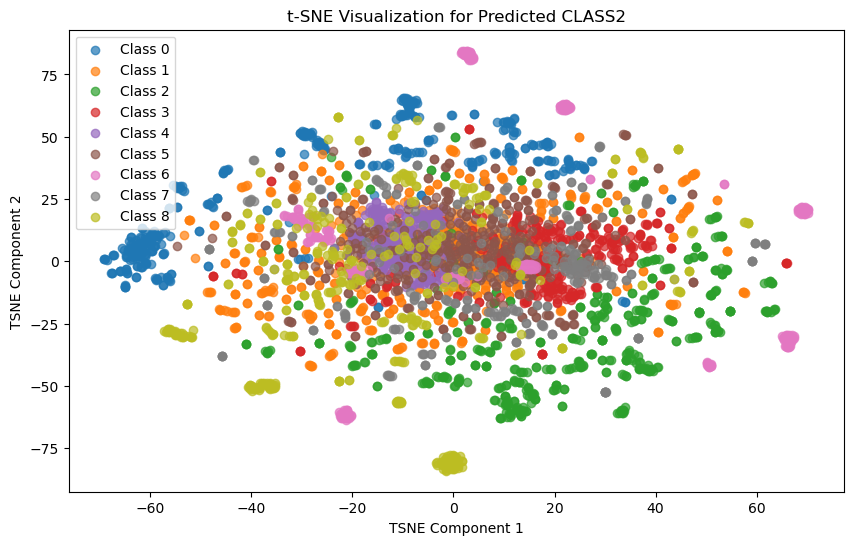

In [147]:
predicted_labels_class1 = np.argmax(image_nn_class1.predict(X_test_image), axis=1)
predicted_labels_class2 = np.argmax(image_nn_class2.predict(X_test_image), axis=1)

plot_tsne(X_test_image, predicted_labels_class1, 't-SNE Visualization for Predicted CLASS1')
plot_tsne(X_test_image, predicted_labels_class2, 't-SNE Visualization for Predicted CLASS2')